Training second stage neural operator, 7/28

First derivative, 3-layer CNN, relu activation, multistage

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime

In [2]:
save = True
cluster = True

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [6]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000

# Uncomment below to create dataset
# dataset = FourierSeriesDataset(num_samples, num_points)

# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'datasets/both_derivatives_dataset.pt')

## Load previously saved dataset

In [7]:
if cluster:
    dataset = torch.load('both_derivatives_dataset.pt')
else:
    dataset = torch.load('datasets/both_derivatives_dataset.pt')

In [8]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [10]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


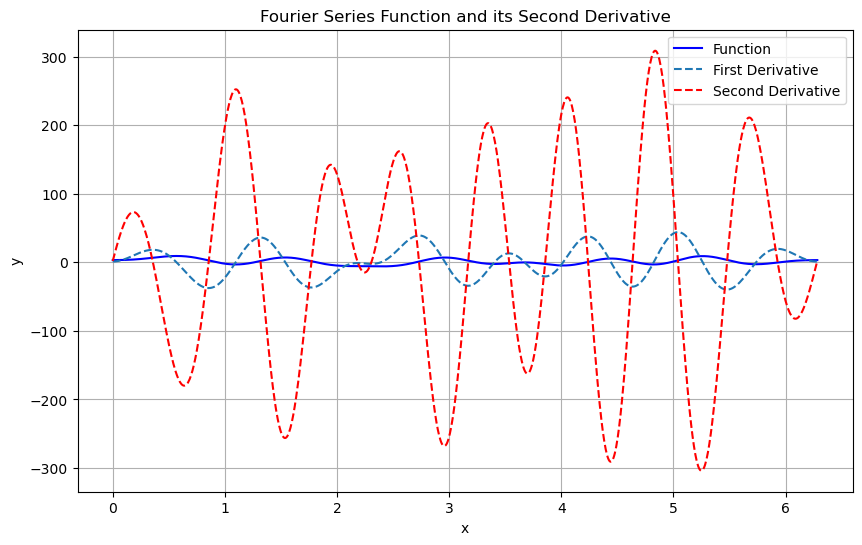

In [11]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

This version of the CNN uses three layers.

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [13]:
# to use model from cluster, use
model1.load_state_dict(torch.load('models/E1000_D1_3L_AFrelu_1S.pth'))

<All keys matched successfully>

## Training loop

In [14]:
train_losses, test_losses = [], []

In [15]:
# Training loop
def model_training(model1, num_epochs, order=None):
    train_losses = []
    test_losses = []

    optimizer = optim.Adam(model1.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, batch_second_derivatives in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)
            batch_second_derivatives = batch_second_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, b_test_second_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)
                b_test_second_derivatives = b_test_second_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

**Uncomment below to train and save the model**


In [16]:
# train_losses, test_losses = model_training(model1, 1000, order='first')
# torch.save(model1.state_dict(), 'models/E1000_D1_3L_AFrelu_1S.pth')

In [17]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [18]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/inverse', filename='D1_3L_AFrelu_1S_loss', save=save)

In [19]:
def plot_output(model1, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative, true_second_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()
    true_second_derivative = true_second_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')
    if order == 2:
        plt.plot(x, true_second_derivative, label=f'True {order}nd derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

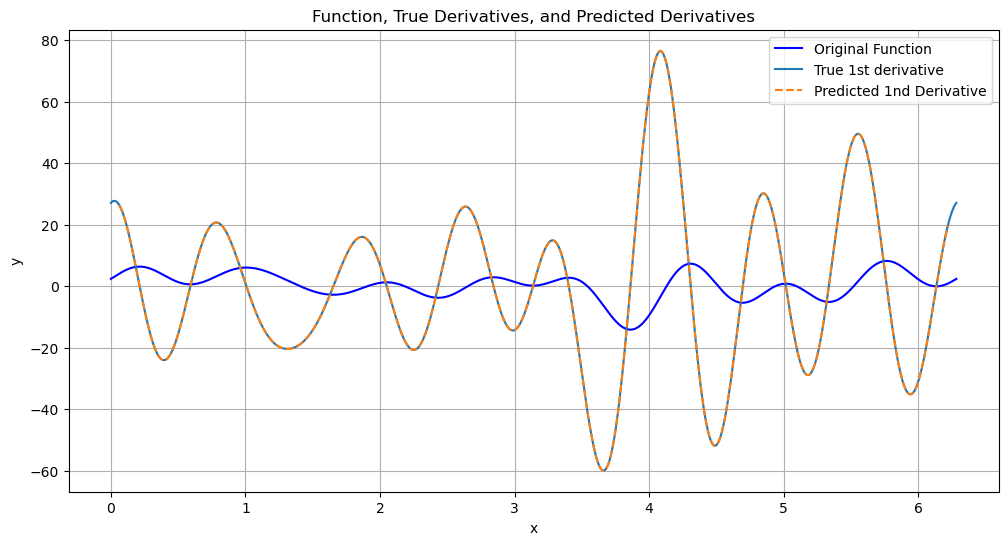

In [20]:
plot_output(model1, order=1, save_dir='plots', filename='D1_3L_AFrelu_1S_output', save=save)

## Calculate accuracy (MSE)

MSE is computed as: $\frac{1}{n} \sum (y-f(x))^2$

In [21]:
def calculate_combined_output(model1, model2, function_input, true_derivative):
    # Predict the derivative from the first model
    output = model1(function_input)

    # Compute the residual and root mean squared error
    residual = output.squeeze() - true_derivative
    rms = torch.sqrt(torch.mean(residual**2))

    # Predict the derivative from the second model
    output2 = model2(function_input)

    # Calculate the combined model output
    combined_model_output = output + rms * output2

    return combined_model_output

In [22]:
def compute_mse(dataset, model1, model2=None):
    all_outputs = []
    all_targets = []

    dataloader = DataLoader(dataset)
    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    # print(f"Overall MSE over all test functions: {mse.item()}")
    return mse.item()

print(f"MSE over all test functions: {compute_mse(test_dataset, model1)}")

MSE over all test functions: 0.0010759654687717557


## Normalized MSE

NMSE is computed as: $\frac{1}{n} \frac{\sum (y-f(x))^2}{\sum y^2}$

In [23]:
def compute_nmse(dataset, model1, model2=None):
    all_outputs = []
    all_targets = []

    dataloader = DataLoader(dataset)
    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    normalizing_factor = torch.mean(all_targets ** 2)

    nmse = mse / normalizing_factor

    # print(f"Overall NMSE over all test functions: {nmse.item()}")
    return nmse.item()
print(f"NMSE over all test functions: {compute_nmse(test_dataset, model1)}")

NMSE over all test functions: 4.503606760408729e-06


## Spectral biases from Fourier Transform

In [24]:
def calculate_median_frequency(function):
    fft_coeffs = np.fft.fft(function)
    freqs = np.fft.fftfreq(len(function))
    power_spectrum = np.abs(fft_coeffs)**2
    significant_freqs = freqs[power_spectrum > (np.max(power_spectrum) * 0.01)]
    return np.median(np.abs(significant_freqs))

def categorize_functions(dataloader):
    functions_with_freqs = []
    
    for functions, derivatives, sec_derivative in dataloader:
        for idx, function in enumerate(functions):
            median_frequency = calculate_median_frequency(function.numpy())
            functions_with_freqs.append((function.numpy(), derivatives[idx].numpy(), sec_derivative[idx].numpy(), median_frequency))
    
    # Sort by median frequency
    functions_with_freqs.sort(key=lambda x: x[3])
    
    # Split into low and high frequency datasets
    mid_index = len(functions_with_freqs) // 2
    low_freq_dataset = functions_with_freqs[:mid_index]
    high_freq_dataset = functions_with_freqs[mid_index:]
    
    # Create new DataLoaders, excluding the median frequency from the data
    # Each dataloader contains the function, deriv, and second deriv
    low_freq_dataloader = [(f[0], f[1], f[2]) for f in low_freq_dataset]
    high_freq_dataloader = [(f[0], f[1], f[2]) for f in high_freq_dataset]
    
    return low_freq_dataloader, high_freq_dataloader

In [25]:
# use the test dataset to compute frequencies
# Should be half of full dataset in each dataloader
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

Low frequency dataset size: 992
High frequency dataset size: 992


In [26]:
# print(f"MSE over low freq functions: {compute_mse(low_freq_dataset, model1)}")
# print(f"NMSE over low freq functions: {compute_nmse(low_freq_dataset, model1)}")

In [27]:
# print(f"MSE over high freq functions: {compute_mse(high_freq_dataset, model1)}")
# print(f"NMSE over high freq functions: {compute_nmse(high_freq_dataset, model1)}")

### Plotting errors

In [28]:
def plot_difference(model1, dataset, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode
    
    current_date = datetime.now().strftime("%m-%d")

    def plot_sliced(x, y, label, linestyle='-'):
        plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)

    plt.figure(figsize=(12, 12))  # Adjust figure size for a 2x2 grid
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(dataset, shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = true_derivative - predicted_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = true_second_derivative - predicted_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        true_derivative = true_derivative.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()
        
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()

        plt.subplot(2, 2, i)  # Adjust subplot position
        plot_sliced(x, function, '$u$')
        plot_sliced(x, first_deriv_diff, "$u'_g - u'_{\\theta}$", linestyle='--')
        # plot_sliced(x, true_derivative, "$u'_g$")
        # plot_sliced(x, true_second_derivative, "$u''_g$", linestyle='--')

        plt.title(f'Difference for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        mse = np.mean((first_deriv_diff) ** 2)
        nmse = mse / np.mean(true_derivative ** 2)

        print(f"MSE for function {i} is: {mse}")        
        print(f"NMSE for function {i} is: {nmse}\n")        
    
    if save:
        filename = f"{filename}_{current_date}.png"
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


In [29]:
def plot_difference_separate(model1, dataset, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode

    def plot_sliced(x, y, label, linestyle='-'):
        plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)

    current_date = datetime.now().strftime("%m-%d")

    plt.figure(figsize=(12, 6*4))  # Adjust figure size for side-by-side plots
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(dataset, shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = true_derivative - predicted_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = true_second_derivative - predicted_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        true_derivative = true_derivative.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()
        
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()

        # Plot original function and its derivative
        plt.subplot(4, 2, 2*i-1)  # Adjust subplot position for original function
        plot_sliced(x, function, '$u$', linestyle='-')
        # plot_sliced(x, true_derivative, "$u'$", linestyle='--')
        plt.title(f'Function {i} and its derivative')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        # Plot difference (error)
        plt.subplot(4, 2, 2*i)  # Adjust subplot position for difference plot
        plot_sliced(x, first_deriv_diff, "$u'_g - u'_{\\theta}$", linestyle='--')
        plt.title(f'Error in derivative for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        mse = np.mean((first_deriv_diff) ** 2)
        nmse = mse / np.mean(true_derivative ** 2)

        print(f"MSE for function {i} is: {mse}")        
        print(f"NMSE for function {i} is: {nmse}\n")        

    if save:
        filename = f"{filename}_{current_date}.png"
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


## Second stage training

In [30]:
class ResidualDataset(Dataset):
    def __init__(self, original_dataset, residuals):
        self.original_dataset = original_dataset
        self.residuals = residuals

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        function, _, _ = self.original_dataset[idx]
        return function, self.residuals[idx]

        # will need to modify this to include the second derivative at some point

In [31]:
def compute_normalized_residual(model, dataloader):
    model.eval() # model1 is the trained first stage network
    residuals = []
    with torch.no_grad():
        for function, derivative, second_derivative in dataloader:
            function = function.unsqueeze(1)
            outputs = model(function) # compute the first stage network outputs
            
            outputs = outputs.squeeze() # remove the extra batch dimension after model has computed outputs
            residual = outputs - derivative # computing the difference between predicted derivative and true first derivative
            # residual is a vector that should have shape 32,1000
            residuals.append(residual)
            
    residuals = torch.cat(residuals, dim=0)
    # print(f"Residuals: {residuals[0]}")
    rms = torch.sqrt(torch.mean(residuals**2))
    print(f"rms: {rms}")
    normalized_residuals = residuals / rms
    return normalized_residuals, rms

Compute normalized residuals

In [32]:
# use the first stage network ("model" corresponds to the first stage of training)
train_residuals, train_rms = compute_normalized_residual(model1, train_dataloader)
test_residuals, test_rms = compute_normalized_residual(model1, test_dataloader)

# Create residual datasets: contains the original functions and their residuals from the first stage
residual_train_dataset = ResidualDataset(train_dataset, train_residuals)
residual_test_dataset = ResidualDataset(test_dataset, test_residuals)

# Create dataloaders for residual data
residual_train_dataloader = DataLoader(residual_train_dataset, batch_size=32, shuffle=True, drop_last=True)
residual_test_dataloader = DataLoader(residual_test_dataset, batch_size=32, shuffle=False, drop_last=True)

rms: 0.031597256660461426
rms: 0.0328490287065506


The RMS is almost equal between the train and test datasets.

In [33]:
second_stage_model = SimpleCNN()
residual_optimizer = optim.Adam(second_stage_model.parameters())

In [34]:
second_stage_train_losses, second_stage_test_losses = [], []
def second_stage_model_training(model, num_epochs, order=None):

    model = second_stage_model
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        # no batch_second_derivatives in residual_train_dataloader
        for batch_functions, residuals in residual_train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            residuals = residuals.unsqueeze(1)

            # Forward pass
            outputs = model(batch_functions)
            loss = criterion(outputs, residuals) # criterion is MSE between the model output and the residual
            # the point is to train this model to predict the residual from the original function

            # backward pass
            residual_optimizer.zero_grad()
            loss.backward()
            residual_optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in residual_test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)
                # b_test_second_derivatives = b_test_second_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

In [35]:
# second_stage_train_losses, second_stage_test_losses = second_stage_model_training(second_stage_model, 1000, order='first')
# torch.save(second_stage_model.state_dict(), 'models/E1000_D1_3L_AFrelu_2S.pth')

**Uncomment this code to load the second stage model**

In [36]:
# second_stage_model.load_state_dict(torch.load('models/E1000_D1_3L_AFrelu_2S.pth'))

Need to uncomment these cells (above and below) later

In [37]:
plot_losses(train_losses=second_stage_train_losses, test_losses=second_stage_test_losses,\
    filename='second_stage_loss', save=save)

In [38]:
# print(f"Second stage MSE over all train functions: {compute_mse(train_dataset, model1, second_stage_model)}")
# print(f"Second stage MSE over all test functions: {compute_mse(test_dataset, model1, second_stage_model)}")
# print(f"Second stage MSE over low freq functions: {compute_mse(low_freq_dataset, model1, second_stage_model)}")
# print(f"Second stage MSE over high freq functions: {compute_mse(high_freq_dataset, model1, second_stage_model)}\n")

In [39]:
# print(f"Second stage NMSE over all train functions: {compute_nmse(train_dataset, model1, second_stage_model)}")
# print(f"Second stage NMSE over all test functions: {compute_nmse(test_dataset, model1, second_stage_model)}")
# print(f"Second stage NMSE over low freq functions: {compute_nmse(low_freq_dataset, model1, second_stage_model)}")
# print(f"Second stage NMSE over high freq functions: {compute_nmse(high_freq_dataset, model1, second_stage_model)}")

## Inverse model training (going from u' to u)

Below not necessary anymore

In [40]:
# def get_inverse_predictions(model1, train_dataloader):
#     model1.eval()

#     all_functions = []
#     all_predictions = []
    

#     for batch_functions, batch_derivatives, _ in train_dataloader:

#         batch_functions = batch_functions.unsqueeze(1)
#         outputs = model1(batch_functions).squeeze()
#         batch_functions = batch_functions.squeeze()

#         all_functions.append(batch_functions)
#         all_predictions.append(outputs)
            
#     all_functions = torch.cat(all_functions, dim=0)
#     all_predictions = torch.cat(all_predictions, dim=0)
    
#     # Combine into a single dataset
#     combined_dataset = TensorDataset(all_functions, all_predictions)
    
#     # Create a new DataLoader to handle the paired data
#     paired_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True, drop_last=True)
    
#     return paired_dataloader

In [41]:
inverse_model = SimpleCNN()

**Pass in the first stage model to get the predicted derivatives: model1**

inverse_model will be trained using the predictions from model1

In [42]:
# Training loop
train_losses, test_losses = [], []
def inverse_model_training(model, train_dataloader, test_dataloader, num_epochs, order=None):
    train_losses = []
    test_losses = []

    # dataloader should be function_derivative_pairs

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for functions, derivatives, _ in train_dataloader:
            functions = functions.detach().unsqueeze(1)
            derivatives = derivatives.detach().unsqueeze(1)

            # We want this model to be the inverse model now: compute original function
            outputs = model(derivatives).squeeze()
            functions = functions.squeeze()
            loss = criterion(outputs, functions)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for test_functions, test_derivatives, _ in test_dataloader:
                test_functions = test_functions.detach().unsqueeze(1)
                test_derivatives = test_derivatives.detach().unsqueeze(1)

                outputs = model(test_derivatives).squeeze()
                test_functions = test_functions.squeeze()
                
                loss = criterion(outputs, test_functions)
                test_loss += loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

In [68]:
# train_losses, test_losses = inverse_model_training(inverse_model, train_dataloader,\
#     test_dataloader, 1000, order='first')

Epoch [1/1000], Train Loss: 5.3283, Test Loss: 5.0605
Epoch [2/1000], Train Loss: 5.2426, Test Loss: 5.0393
Epoch [3/1000], Train Loss: 5.0915, Test Loss: 4.9026


KeyboardInterrupt: 

In [44]:
# torch.save(inverse_model.state_dict(), 'models/inverse/E1000_D1_3L_AFrelu_inverse.pth')

In [45]:
inverse_model.load_state_dict(torch.load('models/E3000_D1_3L_AFrelu_inverse.pth'))

<All keys matched successfully>

In [46]:
def compute_mse(dataloader, model):
    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv, _ in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute inverse model output using true derivative and true function
        model_output = model(deriv)
        all_targets.append(function)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)
    # print(f"Overall MSE over all test functions: {mse.item()}")

    return mse.item(), nmse.item()

### MSE for inverse model (between u_g and g(u_g'))


In [47]:
print(f"Train MSE: {compute_mse(train_dataloader, inverse_model)[0]},\
    Train NMSE: {compute_mse(train_dataloader, inverse_model)[1]}")

print(f"Test MSE: {compute_mse(test_dataloader, inverse_model)[0]},\
    Test NMSE: {compute_mse(test_dataloader, inverse_model)[1]}")

Train MSE: 7.129236698150635,    Train NMSE: 0.5958999991416931
Test MSE: 7.017801284790039,    Test NMSE: 0.5938766598701477


In [48]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/inverse', filename='D1_3L_AFrelu_1S_inverse_loss', save=save)

In [49]:
def plot_output(model, order=None, save_dir='plots', filename=None, save=False): 
    model.eval()  # Set the model to evaluation mode

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")

    dataiter = iter(test_dataloader)
    function_batch, deriv_batch, _ = next(dataiter)
    function, deriv = function_batch[0], deriv_batch[0]

    # Reshape the input for the model
    deriv = deriv.unsqueeze(0)
    print(f"deriv shape: {deriv.shape}")

    # Make prediction
    with torch.no_grad():
        predicted_function = model(deriv)

    deriv = deriv.squeeze().detach().numpy()
    print(f"deriv shape: {deriv.shape}")


    predicted_function = predicted_function.squeeze().numpy()
    print(f"function shape: {function.shape}")
    
    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()


    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x, function, label='Original Function', color='blue')
    plt.plot(x, deriv, label=f'Predicted {order}st derivative')
    plt.plot(x[10:-10], predicted_function[10:-10], label=f'Predicted function', linestyle='--')

    plt.title('Function and inverse function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

deriv shape: torch.Size([1, 1000])
deriv shape: (1000,)
function shape: torch.Size([1000])


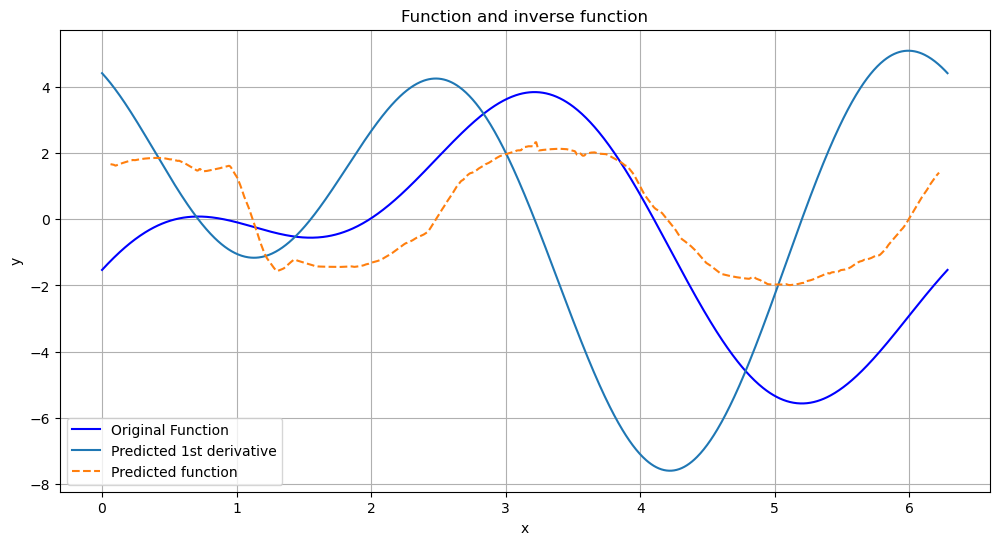

In [50]:
plot_output(inverse_model, order=1, save_dir='plots/inverse', filename='D1_3L_AFrelu_1S_inverse_output', save=save)

## Second stage training based on inverse residue

Need to create a new dataset consisting of $(u_g-u_w, u_g'-u_w')$ and train a second stage model

In [51]:
def create_residue_dataset(forward_model, inverse_model, dataloader):
    forward_model.eval()
    inverse_model.eval()

    all_inputs = []
    all_outputs = []
    
    for functions, derivatives, _ in dataloader:

        functions = functions.unsqueeze(1)
        derivatives = derivatives.unsqueeze(1)

        u_w = inverse_model(derivatives)
        u_w_prime = forward_model(functions)

        first_stage_res = functions.squeeze() - u_w.squeeze()
        second_stage_res = derivatives.squeeze() - u_w_prime.squeeze()

        all_inputs.append(first_stage_res)
        all_outputs.append(second_stage_res)
            
    all_inputs = torch.cat(all_inputs, dim=0)
    all_outputs = torch.cat(all_outputs, dim=0)
    
    # Combine into a single dataset
    combined_dataset = TensorDataset(all_inputs, all_outputs)
    
    # Create a new DataLoader to handle the paired data
    paired_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True, drop_last=True)
    
    return paired_dataloader

In [73]:
residue_train_dataloader = create_residue_dataset(model1, inverse_model, train_dataloader)
residue_test_dataloader = create_residue_dataset(model1, inverse_model, test_dataloader)

# note that this data will be in the order of u_g - u_w, u_g' - u_w'

### Why is the below weird?

In [54]:
# dataloader = iter(residue_dataloader)

# # Retrieve the first pair of input and output
# first_input, first_output = next(dataloader)

# # Assuming input and output are numpy arrays or tensors, convert them to numpy if needed
# # For example, if using PyTorch:
# first_input = first_input[0].detach().numpy()
# first_output = first_output[0].detach().numpy()

# # Plotting the input and output on the same plot
# plt.figure(figsize=(10, 5))
# plt.plot(first_input, label="$u_g - g(u_g')$")
# plt.plot(first_output, label="$u_g' - f(u_g')$", linestyle='--')
# plt.legend()
# plt.title('Input and Output Overlaid')
# plt.xlabel('X-axis label')  # Customize as needed
# plt.ylabel('Y-axis label')  # Customize as needed
# plt.show()

In [75]:
continued_model1 = SimpleCNN() # model for unscaled data
continued_model2 = SimpleCNN() # model for scaled data

### Scaled MSE

In [83]:
def scaled_mse_loss(outputs, targets, epsilon=1e-5):
    mse = torch.nn.functional.mse_loss(outputs, targets)
    return mse / epsilon

In [84]:
# Training loop
train_losses, test_losses = [], []
def continued_training(model, num_epochs, train_dataloader, test_dataloader, order=None):
    train_losses = []
    test_losses = []

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for function_res, deriv_res in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]

            function_res = function_res.unsqueeze(1).detach()
            deriv_res = deriv_res.unsqueeze(1).detach()

            # Forward pass
            outputs = model(function_res)

            loss = scaled_mse_loss(outputs, deriv_res)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for function_res, deriv_res in test_dataloader:
                # Reshape input: [batch_size, 1, num_points]

                function_res = function_res.unsqueeze(1)
                deriv_res = deriv_res.unsqueeze(1)

                # Forward pass
                outputs = model(function_res)

                loss = scaled_mse_loss(outputs, deriv_res)
                test_loss += loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

In [86]:
train_losses, test_losses = continued_training(continued_model1, 5, residue_train_dataloader,\
    residue_test_dataloader, order=1)

Epoch [1/5], Train Loss: 75.8678, Test Loss: 84.3164
Epoch [2/5], Train Loss: 75.5398, Test Loss: 82.7348
Epoch [3/5], Train Loss: 75.5170, Test Loss: 83.9700


KeyboardInterrupt: 

In [ ]:
torch.save(continued_model1.state_dict(), 'models/E1000_D1_3L_AFrelu_continued_scaled.pth')

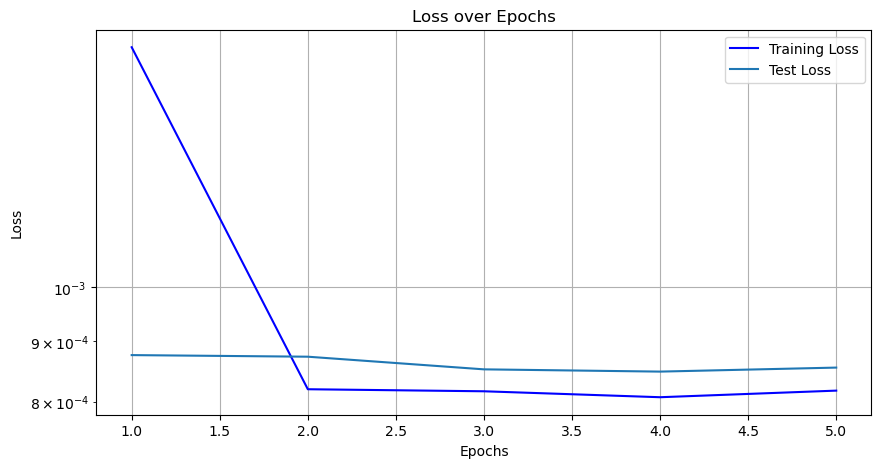

In [79]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/inverse', filename='D1_3L_AFrelu_continued_loss', save=save)